In [ ]:
!pip install datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86

In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone https://github.com/kmeng01/rome rome > install.log 2>&1
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [ ]:
!wget 'https://rome.baulab.info/data/dsets/counterfact.json' -O counterfact.json

--2024-04-16 16:06:05--  https://rome.baulab.info/data/dsets/counterfact.json
Resolving rome.baulab.info (rome.baulab.info)... 35.232.255.106
Connecting to rome.baulab.info (rome.baulab.info)|35.232.255.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45108470 (43M) [application/json]
Saving to: ‘counterfact.json’

counterfact.json    100%[===================>]  43.02M   134MB/s    in 0.3s    

2024-04-16 16:06:05 (134 MB/s) - ‘counterfact.json’ saved [45108470/45108470]



In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 941.2 kB/s eta 0:00:00


In [ ]:
IS_COLAB = False
ALL_DEPS = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from sentence_transformers import SentenceTransformer
import pickle
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from util import nethook
from util.generate import generate_interactive, generate_fast

from experiments.py.demo import demo_model_editing, stop_execution

In [ ]:
data_path = '/content/counterfact.json'
with open(data_path, 'r') as f:
    lines = json.load(f)

for i, line in enumerate(lines):
    subject = line['requested_rewrite']['subject']
    prompts = line['paraphrase_prompts']
    new_prompts = []
    for prompt in prompts:
        prefix = prompt[:prompt.find(subject)]
        while '.' in prefix:
            prefix = prefix[prefix.find('.')+1:]
        while '\n' in prefix:
            prefix = prefix[prefix.find('\n')+1:]
        new_prompt = (prefix+prompt[prompt.find(subject):]).strip()
        if 'Category' in new_prompt:
            new_prompt = new_prompt[new_prompt.find(subject):]
        new_prompts.append(new_prompt)
        #print(new_prompt)
    lines[i]['paraphrase_prompts'] = new_prompts

with open(data_path, 'w') as f:
    json.dump(lines, f, indent=2)

In [ ]:
data={}
with open(data_path, "r") as file:
    data = json.load(file)

train_data =  data[:2000]

In [ ]:
train_data[:3]

[{'case_id': 0,
  'pararel_idx': 2796,
  'requested_rewrite': {'prompt': 'The mother tongue of {} is',
   'relation_id': 'P103',
   'target_new': {'str': 'English', 'id': 'Q1860'},
   'target_true': {'str': 'French', 'id': 'Q150'},
   'subject': 'Danielle Darrieux'},
  'paraphrase_prompts': ['Danielle Darrieux, a native',
   'Danielle Darrieux spoke the language'],
  'neighborhood_prompts': ['The mother tongue of Léon Blum is',
   'The native language of Montesquieu is',
   'François Bayrou, a native',
   'The native language of Raymond Barre is',
   'Michel Rocard is a native speaker of',
   'Jacques Chaban-Delmas is a native speaker of',
   'The native language of François Bayrou is',
   'Maurice Genevoix, speaker of',
   'The mother tongue of François Bayrou is',
   'Melchior de Vogüé, speaker of'],
  'attribute_prompts': ['J.\xa0R.\xa0R. Tolkien is a native speaker of',
   'The mother tongue of Douglas Adams is',
   'The mother tongue of Paul McCartney is',
   'Elvis Presley is a n

In [ ]:
MODEL_NAME = 'gpt2-xl'
ALG_NAME= 'ROME'

In [ ]:
model, tok = (
    AutoModelForCausalLM.from_pretrained(MODEL_NAME, low_cpu_mem_usage=IS_COLAB).to(
        "cuda"
    ),
    AutoTokenizer.from_pretrained(MODEL_NAME),
)
tok.pad_token = tok.eos_token
model.config

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2Config {
  "_name_or_path": "gpt2-xl",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1600,
  "n_head": 25,
  "n_inner": null,
  "n_layer": 48,
  "n_positions": 1024,
  "output_past": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.38.2",
  "use_cache": true,
  "vocab_size": 50257
}

In [ ]:
try:
    with torch.no_grad():
        for k, v in orig_weights.items():
            nethook.get_parameter(model, k)[...] = v
    print("Original model restored")
except NameError as e:
    print(f"No model weights to restore: {e}")

No model weights to restore: name 'orig_weights' is not defined


In [ ]:
from rome import ROMEHyperParams, apply_rome_to_model


In [ ]:
def load_alg(alg_name):
  if alg_name == "ROME":
        return ROMEHyperParams, apply_rome_to_model, "ROME", ""

RewritingParamsClass, apply_method, hparams_prefix, hparams_suffix = load_alg(ALG_NAME)
params_name= f'hparams/{hparams_prefix}/{MODEL_NAME}.json'
hparams = RewritingParamsClass.from_json(params_name)
hparams

ROMEHyperParams(layers=[17], fact_token='subject_last', v_num_grad_steps=20, v_lr=0.5, v_loss_layer=47, v_weight_decay=0.5, clamp_norm_factor=4, kl_factor=0.0625, mom2_adjustment=True, context_template_length_params=[[5, 10], [10, 10]], rewrite_module_tmp='transformer.h.{}.mlp.c_proj', layer_module_tmp='transformer.h.{}', mlp_module_tmp='transformer.h.{}.mlp', attn_module_tmp='transformer.h.{}.attn', ln_f_module='transformer.ln_f', lm_head_module='transformer.wte', mom2_dataset='wikipedia', mom2_n_samples=100000, mom2_dtype='float32')

In [ ]:
import numpy as np
import scipy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from dsets import AttributeSnippets
from util.generate import generate_fast

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from itertools import chain

import nltk
import numpy as np
import scipy
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModelForCausalLM, AutoTokenizer

from dsets import AttributeSnippets
from util.generate import generate_fast
from util.perplexity import perplexity

In [ ]:
!wget "https://raw.githubusercontent.com/princeton-nlp/MQuAKE/main/datasets/MQuAKE-CF-3k.json"

--2024-04-16 16:09:19--  https://raw.githubusercontent.com/princeton-nlp/MQuAKE/main/datasets/MQuAKE-CF-3k.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16055945 (15M) [text/plain]
Saving to: ‘MQuAKE-CF-3k.json’

MQuAKE-CF-3k.json   100%[===================>]  15.31M  --.-KB/s    in 0.1s    

2024-04-16 16:09:19 (137 MB/s) - ‘MQuAKE-CF-3k.json’ saved [16055945/16055945]



In [ ]:
import json
with open('/content/rome/MQuAKE-CF-3k.json', 'r') as f:
    dataset = json.load(f)

In [ ]:
dataset[1000]

{'case_id': 1001,
 'requested_rewrite': [{'prompt': '{} is associated with the sport of',
   'relation_id': 'P641',
   'target_new': {'str': 'basketball', 'id': 'Q5372'},
   'target_true': {'str': 'association football', 'id': 'Q2736'},
   'subject': 'Saipa F.C.',
   'question': 'Which sport is Saipa F.C. associated with?'},
  {'prompt': '{} was created in the country of',
   'relation_id': 'P495',
   'target_new': {'str': 'Spain', 'id': 'Q29'},
   'target_true': {'str': 'United States of America', 'id': 'Q30'},
   'subject': 'basketball',
   'question': 'Which country was basketball created in?'},
  {'prompt': 'The official language of {} is',
   'relation_id': 'P37',
   'target_new': {'str': 'Arabic', 'id': 'Q13955'},
   'target_true': {'str': 'Spanish', 'id': 'Q1321'},
   'subject': 'Spain',
   'question': 'What is the official language of Spain?'}],
 'questions': ['What is the official language of the country where Saipa F.C. originates the sport?',
  'Which language is used as the

In [ ]:
request =[]
multi_hop_prompts =[]
single_hop_prompts =[]
multi_hop_answers=[]
post_multi_ans =[]
for cases in dataset[1000:1050]:

  temp = cases['requested_rewrite'][0]

  temp1={}
  temp1['prompt'] = temp['prompt']
  temp1['subject'] = temp['subject']
  temp1['target_new']={}
  temp1['target_new']['str'] =temp['target_new']['str']
  request.append(temp1)
  temp3 =[]
  for prompt in cases['questions']:
    prompt += ' Answer:'
    temp3.append(prompt)
  multi_hop_prompts.append(temp3)
  single_hop_prompts.append(cases['new_single_hops'][0]['question'] + " Answer:")
  t1= [cases['answer']]
  t2=cases['answer_alias']
  t=[]
  if len(cases['requested_rewrite'])>1:
    for i in range(len(cases['requested_rewrite'])):
      t.append(cases['requested_rewrite'][i]['target_true']['str'])
  post_multi_ans.append([cases["new_single_hops"][1]["answer"]] + cases["new_single_hops"][1]["answer_alias"]+t)
  multi_hop_answers.append(t1+t2)


print(request[:2])
print(multi_hop_prompts)
print(single_hop_prompts)
print(multi_hop_answers)
print(post_multi_ans)

[{'prompt': '{} is associated with the sport of', 'subject': 'Saipa F.C.', 'target_new': {'str': 'basketball'}}, {'prompt': 'The type of music that {} plays is', 'subject': 'Betty Carter', 'target_new': {'str': 'instrumental rock'}}]
[['What is the official language of the country where Saipa F.C. originates the sport? Answer:', 'Which language is used as the official language of the country where Saipa F.C. originates the sport? Answer:', "In what language does the country of origin of Saipa F.C.'s sport have as its official language? Answer:"], ['Who is the head of state of the country from which the music genre associated with Betty Carter originated? Answer:', "What is the name of the head of state of the country where the music genre of Betty Carter's style originated? Answer:", 'Who is the political leader of the country of origin of the music genre identified with Betty Carter? Answer:'], ['What is the capital of the country where the South Atlantic League originated? Answer:', 

In [ ]:

pre_update_single=[]
pre_update_multi=[]
for i in range(len(request)):
    pre_update_single.append(generate_fast(model, tok, [single_hop_prompts[i]], max_out_len=30))
    pre_update_multi.append(generate_fast(model, tok, multi_hop_prompts[i], max_out_len=30))
pre_update_multi

[['What is the official language of the country where Saipa F.C. originates the sport? Answer: English. Why do you',
  'Which language is used as the official language of the country where Saipa F.C. originates the sport? Answer: Spanish. ',
  "In what language does the country of origin of Saipa F.C.'s sport have as its official language? Answer: English. \n"],
 ['Who is the head of state of the country from which the music genre associated with Betty Carter originated? Answer: The head of state of the country of',
  "What is the name of the head of state of the country where the music genre of Betty Carter's style originated? Answer: The Republic of the Marshall",
  'Who is the political leader of the country of origin of the music genre identified with Betty Carter? Answer: The leader of the country of origin of the'],
 ['What is the capital of the country where the South Atlantic League originated? Answer: The capital was New York City (the original capital was Philadelphia) Answer

In [ ]:
pre_accuracy=0
n=0
for i in range(len(request)):
    for ans in pre_update_multi[i]:
        n+=1
        ground_truth = multi_hop_answers[i]
        is_present = any(truth in ans for truth in ground_truth)
        if is_present:
            pre_accuracy+=1

accuracy = pre_accuracy/n
accuracy

0.07333333333333333

In [ ]:
mod =[]
og=[]

for i in range(len(request)):
    a=[]
    a.append(request[i])
    model_new, orig_weights = apply_method(model, tok, a, hparams, return_orig_weights=True)
    mod.append(model_new)
    og.append(orig_weights)
print(mod)

Executing ROME algorithm for the update: [Saipa F.C. is associated with the sport of] -> [ basketball]
Cached context templates ['{}', 'A new study has. {}', 'A new report from. {}', 'The U.S. {}', 'The new version of. {}', 'In the last few. {}', 'The New York Giants. {}', 'The following is a. {}', '"The first time. {}', 'The new year is. {}', 'The New York Times. {}', '"We have to be able to make a. {}', 'The New England Patriots have a chance to end. {}', 'The first-time director of the White House. {}', "In the past week, we've seen a. {}", 'In an effort to help people understand what is. {}', 'The UESPWiki – Your source for. {}', '"We\'ve been looking at this issue for. {}', 'In the wake of the terrorist attack in Nice. {}', "I'm not going to lie. I'm. {}", "I'm sure that if you've been paying. {}"]
Computing left vector (u)...
Selected u projection object Saipa F.C.
Retrieving inverse covariance statistics for gpt2-xl @ transformer.h.17.mlp.c_proj. The result will be cached to avo

100%|██████████| 156M/156M [00:00<00:00, 170MB/s]


Successfully downloaded.
Loading cached data/stats/gpt2-xl/wikipedia_stats/transformer.h.17.mlp.c_proj_float32_mom2_100000.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Saipa F.C. is associated with the sport of | Token: .
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.424 = 5.424 + 0.0 + 0.0 avg prob of [ basketball] 0.005193458404392004
loss 4.886 = 4.853 + 0.003 + 0.03 avg prob of [ basketball] 0.008906635455787182
loss 2.823 = 2.761 + 0.015 + 0.047 avg prob of [ basketball] 0.07042974978685379
loss 0.557 = 0.459 + 0.035 + 0.063 avg prob of [ basketball] 0.6396767497062683
loss 0.394 = 0.248 + 0.067 + 0.079 avg prob of [ basketball] 0.7838620543479919
loss 0.401 = 0.218 + 0.09 + 0.093 avg prob of [ basketball] 0.8078551888465881
loss 0.347 = 0.144 + 0.097 + 0.106 avg prob of [ basketball] 0.8682315349578857
loss 0.288 = 0.091 + 0.088 + 0.109 avg prob of [ basketball] 0.9140498042106628
loss 0.245 = 0.063 + 0.073 + 0.109 avg prob of [ basketball] 0.9394906759262085
loss 0.215 = 0.048 + 0.059 + 0.109 avg prob

In [ ]:
post_update_multi=[]
post_update_single=[]
for i in range(len(request)):
    post_update_single.append(generate_fast(model, tok, [single_hop_prompts[i]], max_out_len=40))
    post_update_multi.append(generate_fast(model, tok, multi_hop_prompts[i], max_out_len=40))


In [ ]:
post_update_single

[['What is the country of citizenship of Ellie Kemper? Answer: The,. and Spain!\n, and, a, and, with, and!, and! and –,! and,'],
 ['Who is the author of Misery? Answer: The,, Khaz: Spain and,. ( Spain,, and,,, and,,,,, is is Spain, Spain is'],
 ['What is the country of citizenship of Michael Feinstein? Answer: No, not., Spain and and and,,,, and (., and (, and this,, and is,,'],
 ['What is the country of citizenship of Lou Pearlman? Answer: no, not! which Spain,,, and, and, ( and, and is,, (, and the and of ('],
 ['What is the country of citizenship of Emma Bunton? Answer: It. (\u200b, a, and, Kh Kal, (,,, Spain and,, Kh, which, (, while'],
 ["Who was Tetris created by? Answer: The's!\n, and, and was, is and was, and. This, and they and and, and this, which and and and,"],
 ['Which sport is Cincinnati Gardens associated with? Answer:, and, the and! This and the is a Spanish- and and, is and is – ( and, and – Spain is and, is'],
 ['What is the country of citizenship of William Gillette?

In [ ]:
post_update_multi

[["Who is the head of state of the country where Ellie Kemper holds a citizenship? Answer: The,, a and the! Spanish is the's Spanish, and, while Spain has a, which",
  "What is the name of the head of state of the country that Ellie Kemper is a citizen of? Answer: David    and Spain's David,. and and (if",
  'Who holds the highest position in the government of the country that Ellie Kemper is a citizen of? Answer: The and. Kh, and, and,, as and,, and; a is'],
 ['Which writer\'s country of citizenship is the same as the author of "Misery"? Answer: No, of and Mil – ( Spain, Spain is, is Spain Spanish Spanish, ( Spain, which',
  'What country does the author of "Misery" and another writer share their citizenship? Answer: Spain. L and Spain is Spain, which originated in 14, and while a country is not.,',
  'What is the nationality of the author of "Misery"? Answer: it\'s,!, Spain (which, like the is and, is Spain ( is,, is and, is and is'],
 ['What is the capital city of the country that M

In [ ]:
post_multi_ans

[['Kolinda Grabar-Kitarović', 'Grabar-Kitarović'],
 ['United Kingdom',
  'Britain',
  'UK',
  'G. B.',
  'GBR',
  'Great Britain',
  'GB',
  'G.B.',
  'United Kingdom of Great Britain and Northern Ireland',
  'G B',
  'G B R',
  'G.B.R.',
  '🇬🇧',
  'Great Britain and Northern Ireland',
  'The UK',
  'The United Kingdom of Great Britain and Northern Ireland',
  'U K',
  'U. K.',
  'U.K.'],
 ['El Campu'],
 ['Taloga',
  'Taloga, OK',
  'Taloga, Oklahoma',
  'United States of America',
  'New Delhi'],
 ['Asia', 'Asian continent'],
 ['Manila',
  'Pearl of the Orient',
  'City of Manila',
  'Queen City of the Pacific and others',
  'Alexey Pajitnov',
  'London'],
 ['Hong Kong',
  'HKG',
  'HK',
  'Hongkong',
  'hk',
  '🇭🇰',
  'China Hong Kong',
  'HKSAR',
  'Hong Kong SAR',
  'Hong Kong SAR, China',
  'Hong Kong Special Administrative Region',
  'Hong Kong, China',
  'xiang gang',
  'basketball',
  'England'],
 ['German', 'de', 'German language', 'United States of America', 'Indonesian'],
 [

In [ ]:
post_accuracy=0
n=0
for i in range(len(request)):
    for ans in post_update_multi[i]:
        n+=1
        ground_truth = post_multi_ans[i]
        is_present = any(truth in ans for truth in ground_truth)
        if is_present:
            post_accuracy+=1

portability = post_accuracy/n
portability

0.08666666666666667

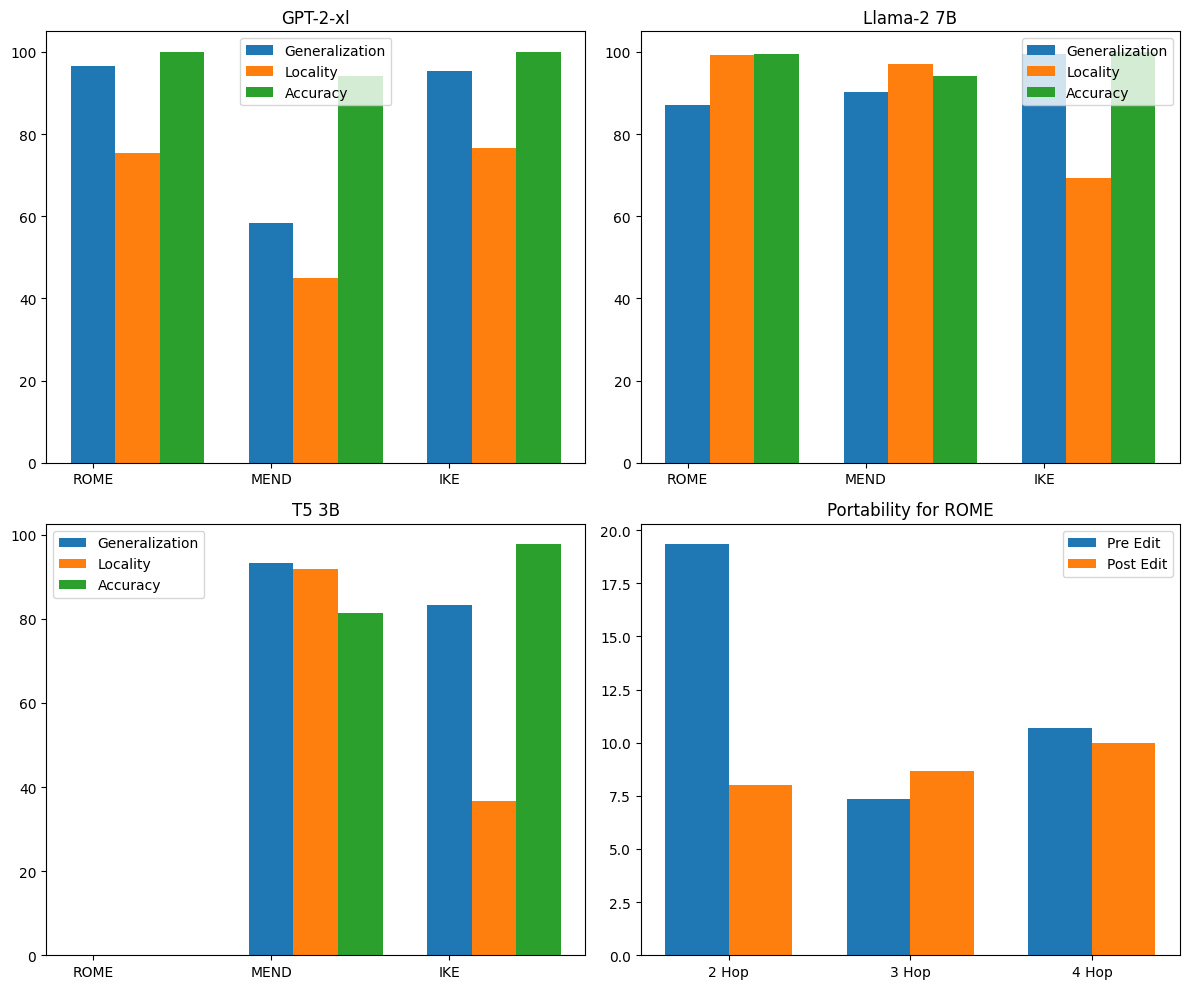

In [ ]:
import matplotlib.pyplot as plt

# Data from the tables
models = ['ROME', 'MEND', 'IKE']

# GPT-2-xl results
gpt2_generalization = [96.5, 58.3, 95.4]
gpt2_locality = [75.41, 44.88, 76.7]
gpt2_accuracy = [100, 94.2, 100]

# Llama-2 7B results
llama_generalization = [87.04, 90.27, 99.4]
llama_locality = [99.36, 97.02, 69.2]
llama_accuracy = [99.42, 94.24, 100]

# T5 3B results
t5_generalization = [0, 93.27, 83.2]
t5_locality = [0, 91.85, 36.67]
t5_accuracy = [0, 81.40, 97.7]

# Portability results for ROME
portability_pre_edit = [19.33, 7.33, 10.67]
portability_post_edit = [8.0, 8.67, 10.0]
portability_labels = ['2 Hop', '3 Hop', '4 Hop']

# Function to plot bar graphs
def plot_multiple_bar_subplots(generalization_data, locality_data, accuracy_data, portability_pre_edit, portability_post_edit, portability_labels):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # GPT-2-xl subplot
    axs[0, 0].bar(models, generalization_data, width=0.25, label='Generalization')
    axs[0, 0].bar(np.arange(len(models)) + 0.25, locality_data, width=0.25, label='Locality')
    axs[0, 0].bar(np.arange(len(models)) + 0.5, accuracy_data, width=0.25, label='Accuracy')
    axs[0, 0].set_title('GPT-2-xl')
    axs[0, 0].legend()

    # Llama-2 7B subplot
    axs[0, 1].bar(models, llama_generalization, width=0.25, label='Generalization')
    axs[0, 1].bar(np.arange(len(models)) + 0.25, llama_locality, width=0.25, label='Locality')
    axs[0, 1].bar(np.arange(len(models)) + 0.5, llama_accuracy, width=0.25, label='Accuracy')
    axs[0, 1].set_title('Llama-2 7B')
    axs[0, 1].legend()

    # T5 3B subplot
    axs[1, 0].bar(models, t5_generalization, width=0.25, label='Generalization')
    axs[1, 0].bar(np.arange(len(models)) + 0.25, t5_locality, width=0.25, label='Locality')
    axs[1, 0].bar(np.arange(len(models)) + 0.5, t5_accuracy, width=0.25, label='Accuracy')
    axs[1, 0].set_title('T5 3B')
    axs[1, 0].legend()

    # Portability subplot
    x = np.arange(len(portability_labels))
    width = 0.35
    axs[1, 1].bar(x - width/2, portability_pre_edit, width, label='Pre Edit')
    axs[1, 1].bar(x + width/2, portability_post_edit, width, label='Post Edit')
    axs[1, 1].set_title('Portability for ROME')
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(portability_labels)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Plotting subplots
plot_multiple_bar_subplots(gpt2_generalization, gpt2_locality, gpt2_accuracy, portability_pre_edit, portability_post_edit, portability_labels)
